# Capstone Project - Distracted Driver Detection -MobileNet

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns 
import os
import cv2
import itertools

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Input
#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

import random

%matplotlib inline

# Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Dataset

In [3]:
train = pd.read_csv("/content/drive/MyDrive/capstone/datasets/driver_imgs_list.csv")
print('Number of samples in trainset : {}'.format(train.shape[0]))
print('Number of classes to predict : {}'.format(len((train.classname).unique())))
train.head()

Number of samples in trainset : 22424
Number of classes to predict : 10


,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


# Split data set by driver id

In [4]:
def custom_train_test_split_images(train_subjects, 
                                   test_subjects,
                                   val_subjects,
                                   dataDir = "/content/drive/MyDrive/capstone/assets/imgs/train", 
                                   labels= ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'],
                                   train=train,
                                   shuffle=True):
    
    x_train, x_val, x_test, y_train, y_val, y_test = [],[],[],[],[],[]
    
    for label in labels:
        path = os.path.join(dataDir, label) #path to labels directory
        class_num = labels.index(label)
        
        for img in os.listdir(path):
            
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) #read image, convert to grayscale
            new_array = cv2.resize(img_array, (224, 224)) #resize
            
            current_subject = train.loc[train['img'] == img, 'subject'].item() #locate all images relating to a driver
            
            if current_subject in train_subjects:
                x_train.append(new_array)
                y_train.append(class_num)
                
            elif current_subject in test_subjects:
                x_test.append(new_array)
                y_test.append(class_num)
                
            elif current_subject in val_subjects:
                x_val.append(new_array)
                y_val.append(class_num)

    if shuffle: #shuffle data
        train_tmp, val_tmp, test_tmp = list(zip(x_train, y_train)), list(zip(x_val, y_val)), list(zip(x_test, y_test))
        random.shuffle(train_tmp)
        random.shuffle(val_tmp)
        random.shuffle(test_tmp)
        
        x_train, y_train = list(zip(*train_tmp))
        x_val, y_val = list(zip(*val_tmp))
        x_test, y_test = list(zip(*test_tmp))

    return x_train, x_val, x_test, y_train, y_val, y_test
            

In [5]:
#code was run on jupyter notebook

# drivers = train.groupby('subject')
# unique_drivers = drivers.groups.keys()

# train_ratio = .5
# test_ratio = .25
# train_subject_len = int(np.floor(len(unique_drivers) * train_ratio))
# test_subject_len = int(np.floor(len(unique_drivers) * (train_ratio + test_ratio)))


# train_subjects = list(unique_drivers)[:train_subject_len]
# test_subjects = list(unique_drivers)[train_subject_len:test_subject_len]
# val_subjects = list(unique_drivers)[test_subject_len:]

# print('train subjects: ', train_subjects)
# print('test subjects: ', test_subjects)
# print('val subjects: ', val_subjects)


# X_train, X_val, X_test, y_train, y_val, y_test = custom_train_test_split_images(train_subjects=train_subjects, 
#                                         test_subjects=test_subjects, 
#                                         val_subjects=val_subjects)

# Preprocess data

In [6]:
#code was run on jupyter notebook

# def preprocess(x_train, x_val, x_test, y_train, y_val, y_test):
#     x_train = np.array(x_train, dtype=np.float32)
#     x_val = np.array(x_val, dtype=np.float32)
#     x_test = np.array(x_test, dtype=np.float32)
    
#     x_train_flat = x_train.reshape(x_train.shape[0],-1)
#     x_val_flat = x_val.reshape(x_val.shape[0],-1)
#     x_test_flat = x_test.reshape(x_test.shape[0],-1)
    
#     ss = StandardScaler()
#     x_train_flat = ss.fit_transform(x_train_flat)
#     x_train_final = x_train_flat.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],-1)
    
#     x_val_flat = ss.transform(x_val_flat)
#     x_val_final = x_val_flat.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2],-1)
    
#     x_test_flat = ss.transform(x_test_flat)
#     x_test_final = x_test_flat.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],-1)
    
#     y_train, y_val, y_test = np_utils.to_categorical(y_train, 10), np_utils.to_categorical(y_val, 10), np_utils.to_categorical(y_test, 10)
    
#     return x_train_final, x_val_final, x_test_final, y_train, y_val, y_test

# X_train, X_val, X_test, y_train, y_val, y_test = preprocess(X_train, X_val, X_test, y_train, y_val, y_test)


# Load Variables from Jupyter Notebook

In [5]:
def load_arr(filename):
    with open(filename, 'rb') as f:
        return np.load(f)

X_train = load_arr('/content/drive/MyDrive/capstone/code/pretrained_models/new_X_train.npy')
X_val = load_arr('/content/drive/MyDrive/capstone/code/pretrained_models/new_X_val.npy')
X_test = load_arr('/content/drive/MyDrive/capstone/code/pretrained_models/new_X_test.npy')
y_train = load_arr('/content/drive/MyDrive/capstone/code/pretrained_models/new_y_train.npy')
y_val = load_arr('/content/drive/MyDrive/capstone/code/pretrained_models/new_y_val.npy')
y_test = load_arr('/content/drive/MyDrive/capstone/code/pretrained_models/new_y_test.npy')

In [6]:
print(X_train.shape)
print(y_train.shape)

(11964, 224, 224, 3)
(11964, 10)


# MobileNet

In [8]:
model_mobilenet= MobileNet(weights= 'imagenet', include_top=False)


x=model_mobilenet.output
x=GlobalAveragePooling2D()(x)


#output layer
preds=Dense(10,activation='softmax')(x)

model = Model(model_mobilenet.input, outputs=preds)

# Compile CNN model
sgd = optimizers.SGD(lr = 0.005)
model.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

#callbacks
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, mode='auto')
checkpointer = ModelCheckpoint('mobilenet_sgd_nolayers.hdf5', verbose=1, save_best_only=True)

In [9]:
datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )

data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
history = model.fit(data_generator,
                    steps_per_epoch = len(X_train) / 64,
                    callbacks=[checkpointer, early_stop],
                    epochs = 25, 
                    verbose = 1, 
                    validation_data = (X_test, y_test))

Epoch 1/25
186/186 [==============================] - 134s 683ms/step - loss: 2.3205 - accuracy: 0.1913 - val_loss: 1.7613 - val_accuracy: 0.4012

Epoch 00001: val_loss improved from inf to 1.76127, saving model to mobilenet_sgd_nolayers.hdf5
Epoch 2/25
186/186 [==============================] - 125s 668ms/step - loss: 1.4208 - accuracy: 0.5481 - val_loss: 1.0769 - val_accuracy: 0.6422

Epoch 00002: val_loss improved from 1.76127 to 1.07693, saving model to mobilenet_sgd_nolayers.hdf5
Epoch 3/25
186/186 [==============================] - 127s 676ms/step - loss: 0.9948 - accuracy: 0.6928 - val_loss: 0.8791 - val_accuracy: 0.6962

Epoch 00003: val_loss improved from 1.07693 to 0.87914, saving model to mobilenet_sgd_nolayers.hdf5
Epoch 4/25
186/186 [==============================] - 125s 668ms/step - loss: 0.7831 - accuracy: 0.7585 - val_loss: 0.7798 - val_accuracy: 0.7351

Epoch 00004: val_loss improved from 0.87914 to 0.77975, saving model to mobilenet_sgd_nolayers.hdf5
Epoch 5/25
186/1

In [11]:
# mobilenet_input = Input(shape = (224, 224, 3), name = 'Image_input')
# base_mobilenet =MobileNet(weights='imagenet',include_top=False, input_tensor= mobilenet_input)

# for layer in base_mobilenet.layers:
#     layer.trainable = False #freeze weights

# last = base_mobilenet.output
# x = Flatten()(last)
# x = Dense(512, activation='relu')(x)
# preds = Dense(10, activation='softmax')(x)
# model = Model(base_mobilenet.input, preds)

# sgd = optimizers.SGD(lr = 0.005)
# model.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

# early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, mode='auto')
# checkpointer = ModelCheckpoint('mobilenet_sgd_nolayers.hdf5', verbose=1, save_best_only=True)

# history = model.fit(X_train,
#                     y_train,
#                     batch_size=256,
#                     validation_data=(X_test, y_test),
#                     epochs=25,
#                     verbose=1,
#                     callbacks = [checkpointer, early_stop])


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 32)    0     

In [11]:
# Evaluate model on test data.
mobilenet_test_score = model.evaluate(X_test, y_test, verbose=1)

mobilenet_test_labels = model.metrics_names

print(f'MobileNet_test {mobilenet_test_labels[0]}  : {mobilenet_test_score[0]}')
print(f'MobileNet_test {mobilenet_test_labels[1]}   : {mobilenet_test_score[1]}')

157/157 [==============================] - 4s 26ms/step - loss: 0.6551 - accuracy: 0.8064
MobileNet_test loss  : 0.6551151871681213
MobileNet_test accuracy   : 0.8063744902610779


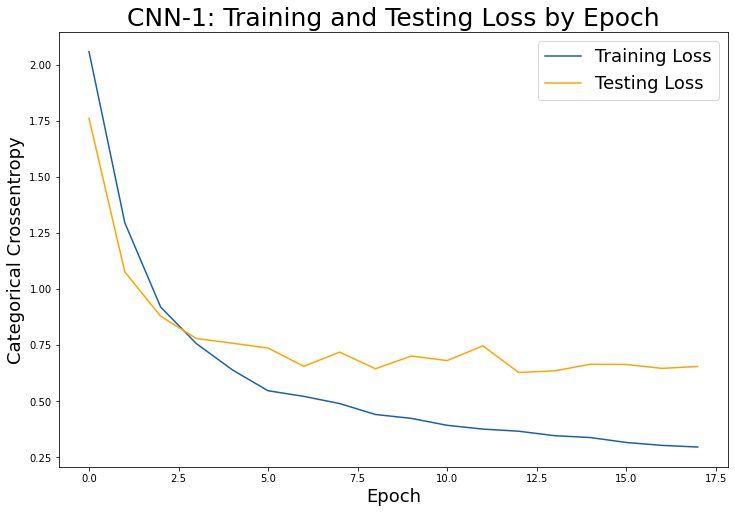

In [12]:
# Check out our train loss and test loss over epochs.
train_loss_1 = history.history['loss']
test_loss_1 = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss_1, label='Training Loss', color='#185fad')
plt.plot(test_loss_1, label='Testing Loss', color='orange')

# Set title
plt.title('CNN-1: Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

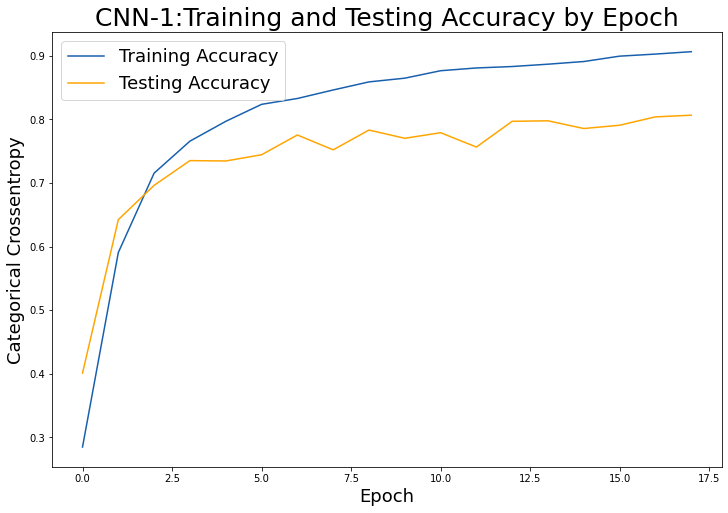

In [13]:
# Check out our train acc and test acc over epochs.
train_acc_1 = history.history['accuracy']
test_acc_1 = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_acc_1, label='Training Accuracy', color='#185fad')
plt.plot(test_acc_1, label='Testing Accuracy', color='orange')

# Set title
plt.title('CNN-1:Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

In [15]:
classes = {"c0": "safe driving", 
           "c1": "texting - right", 
           "c2": "talking on the phone - right", 
           "c3": "texting - left",
           "c4": "talking on the phone - left", 
           "c5": "operating the radio", 
           "c6": "drinking", 
           "c7": "reaching behind",
           "c8": "hair and makeup", 
           "c9": "talking to passenger"}

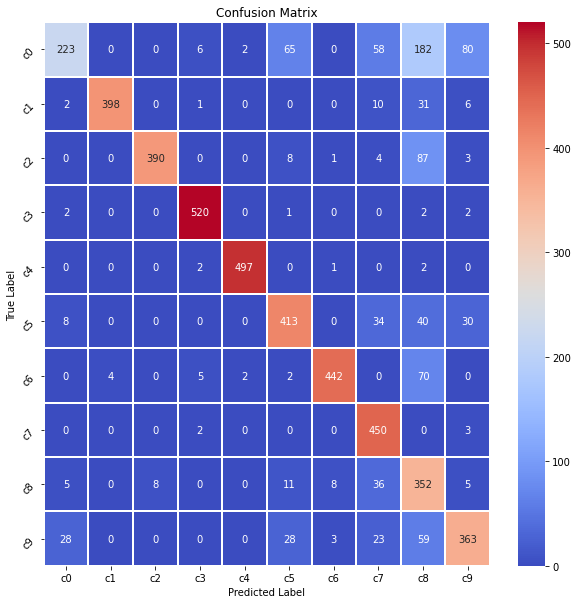

              precision    recall  f1-score   support

           0       0.83      0.36      0.50       616
           1       0.99      0.89      0.94       448
           2       0.98      0.79      0.88       493
           3       0.97      0.99      0.98       527
           4       0.99      0.99      0.99       502
           5       0.78      0.79      0.78       525
           6       0.97      0.84      0.90       525
           7       0.73      0.99      0.84       455
           8       0.43      0.83      0.56       425
           9       0.74      0.72      0.73       504

    accuracy                           0.81      5020
   macro avg       0.84      0.82      0.81      5020
weighted avg       0.85      0.81      0.81      5020



In [16]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=classes,
                yticklabels=classes,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label', rotation=90)
    plt.xlabel('Predicted Label')
    plt.yticks(rotation=45)
    plt.show()

y_pred = model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred = np.argmax(y_pred, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred)

print(classification_report(max_y_test, max_y_pred))

# Predicted Images

In [17]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

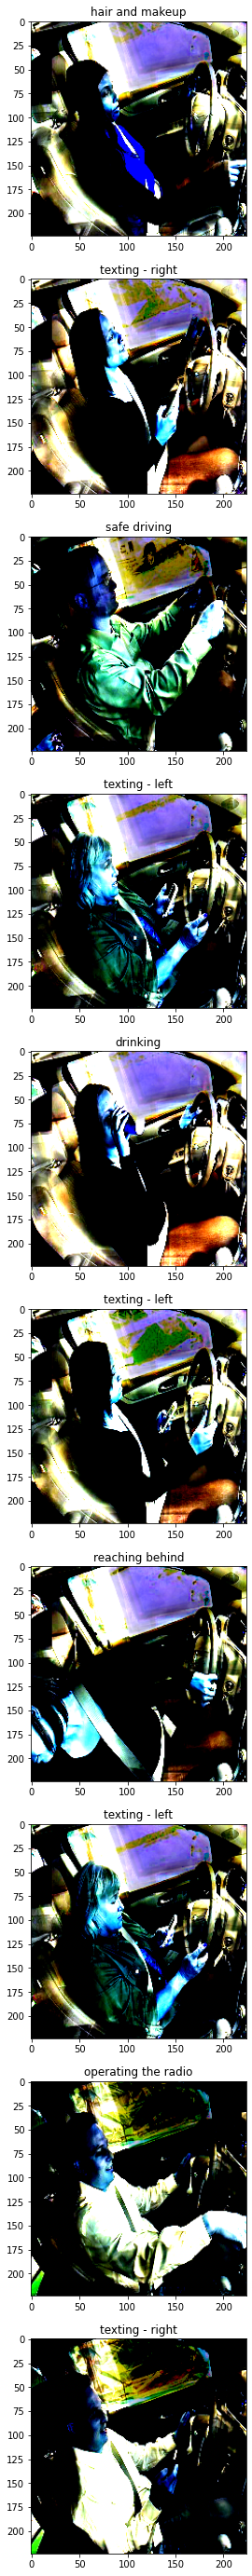

In [18]:
# labels is the image array
i = 0
fig, ax = plt.subplots(10, 1, figsize = (50,50))

for i in range(10):
    ax[i].imshow(X_test[i].squeeze())
    preds_class = 'C'+str(np.where(y_pred[i] == np.amax(y_pred[i]))[0][0])
    ax[i].set_title(tags[preds_class])
    plt.show